In [147]:
#Importing all packages needed for Analyzing the data
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import numpy as np
import seaborn as sns
import math
import re
import textwrap
from adjustText import adjust_text
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
from operator import itemgetter
from matplotlib.ticker import PercentFormatter
from math import isnan

## Helper functions

In [179]:
#This method returns all columns in df that begin with the root
def get_all_related_columns(df, root):
    ret = []
    for col in df.columns:
        if(root.lower() in col.lower()):
            ret.append(col)
    return ret

In [180]:
#Main Color Map - This will be default map used for all returned array unless others
#are specified
main_color_map =  "Reds"

#Helper function to get an array of colors
#Length: How many colors you want
#Lower bound --> The lowerbound for the map
#Upperbound --> The upperbound color for the map
#Colormap --> Uses the default value stored as main_color_map
def get_arr_colors(length=5, colormap=main_color_map, lower = 0.2, upper = 0.7):
    category_colors = plt.get_cmap(colormap)(
            np.linspace(lower, upper,length))
    return category_colors

In [181]:
#Helper function to modify the size of the text and figure
#Can modify whatever values are needed accordingly
def modify_params(size = 14, axes_label_size = 1.0, axes_title_size=1.25,
                x_tick_size = 1.0, y_tick_size = 1, title_pad=25, font_family = 'sans-serif', legend_size = 'xx-large'):
    
    params = {'legend.fontsize': legend_size,
          'axes.labelsize': size*axes_label_size,
          'axes.titlesize': size*axes_title_size,
          'axes.titlepad':title_pad,
          'xtick.labelsize': size*x_tick_size,
          'ytick.labelsize': size,
             'font.family':font_family}
    plt.rcParams.update(params)

In [182]:
#Utility function to analyze multi-select questions
#Given a df and an array of True/False columns, this returns a dataframe that shows
#the percentage for each column
def get_summary(df, arr):
    ret_df = pd.DataFrame(df[arr].apply(np.sum))
    cur_sum = len(df[arr].dropna())
    ret_df['%'] = ret_df.apply(lambda x: round(x[0]*100/cur_sum, 2), axis=1)
    ret_df['Val'] = ret_df.apply(lambda x: '{}% (n={}/{})'.format(x['%'], int(x[0]), cur_sum), axis=1)
    ret_df = ret_df.drop(['%', 0], axis=1)
    col_name = ret_df.index[0].split(' - ')[0]
    ret_df.index = [' - '.join(x.split(' - ')[1:]) for x in ret_df.index]
    ret_df.columns = ['{}, % (total={})'.format(col_name, cur_sum)]
    return ret_df

In [183]:
def show_full_value_counts(df, col):
    cur_df = pd.DataFrame(df[col].value_counts()).sort_index()
    cur_sum = cur_df[col].sum()
    cur_df['%'] = cur_df[col].apply(lambda x: round(x*100/cur_sum, 2))
    cur_df[col] = cur_df.apply(lambda x: '{}% (n={}/{})'.format(x['%'], int(x[col]), int(df[col].notna().sum())), axis=1)
    cur_df = cur_df.drop('%', axis=1)
    cur_df.columns = ['{}, % (total={})'.format(col, df[col].notna().sum())]
    display(cur_df)
    print("Missing cases= {}% (n={}/{})".format(round(df[col].isna().sum()/len(df)*100,2),df[col].isna().sum(), len(df)))

In [184]:
def show_full_value_counts_csv(df, col):
    cur_df = pd.DataFrame(df[col].value_counts()).sort_index()
    cur_sum = cur_df[col].sum()
    cur_df['%'] = cur_df[col].apply(lambda x: round(x*100/cur_sum, 2))
    cur_df[col] = cur_df.apply(lambda x: '{}% (n={}/{})'.format(x['%'], int(x[col]), int(df[col].notna().sum())), axis=1)
    cur_df = cur_df.drop('%', axis=1)
    cur_df.columns = ['{}, % (total={})'.format(col, df[col].notna().sum())]
    print(cur_df.to_csv())

In [185]:
#Utility function to get all the choices for a multi-select question
#Assumes that choices are seperated by ; which is the case for google forms
#Takes into account capitalization of the words
#returns a set of all unique responses found for the specific column
def get_all_choices(df, col):
    ret_set = set()
    [[ret_set.add(y.lower()) for y in x.split(';')] for x in df[col] if pd.notna(x)]
    ret_set =  list(ret_set)
    ret_set.sort()
    return ret_set

In [186]:
#Utility function to display in full
def display_full(inp):
    with pd.option_context('display.max_rows', None, 'display.max_columns', None):
        display(inp)

## Cleanup and Pre-processing

In [187]:
#Reading the data in
df_eng_1 = pd.read_csv('eng_1.csv')
df_eng_2 = pd.read_csv('eng_2.csv')
df_eng_3 = pd.read_csv('eng_3.csv')
df_eng_4 = pd.read_csv('eng_4.csv')
df_eng_5 = pd.read_csv('eng_4.csv')
df_eng_6 = pd.read_csv('eng_6.csv')

In [188]:
df = pd.concat([df_eng_1, df_eng_2, df_eng_3, df_eng_4, df_eng_5, df_eng_6])
df = df.dropna()
df = df.reset_index(drop=True)

print(len(df))

564


In [189]:
df = df.drop(['Timestamp', 'Please check the box below to proceed to the survey:'], axis=1)


In [190]:
print('Duplicated: {}'.format(df.duplicated().sum()))
df = df.drop(df[df.duplicated()].index).reset_index(drop=True)
print('Remaining cases: -- {}'.format(len(df)))

Duplicated: 5
Remaining cases: -- 559


In [191]:
#Trimming all spaces from the choices
df = df.applymap(lambda x: x.strip() if isinstance(x, str) else x)

#Chaning everything to Sentence Case
df = df.applymap(lambda x: x.lower() if isinstance(x, str) else x)

#Removing all random spaces at ends
df.columns = [x.strip() for x in df.columns]

In [192]:
display_full(df.iloc[[3,100,200,300,400],:])

,Sex,Age,Citizenship,Occupation,Department,Health Authority,Workplace,Total Years of Practice,Number of patients seen in a week,Have you received the COVID-19 vaccine?,Have you received the influenza vaccine last year?,Vaccine usage and efficacy.,Vaccine safety.,Role of adjuvants.,What is your main source of information about vaccines recommendation and their safety?,Influenza Vaccine and Guillain-Barré syndrome,Hepatitis B Vaccine and Guillain-Barré syndrome,Hepatitis B Vaccine and Multiple Sclerosis,Aluminum Adjuvants and Alzheimer Disease,Vaccines with Adjuvants and Long-Term Complications,Measles Vaccine and Autism Disorder,Vaccines are an important part of preventive care in my practice.,Giving a strong recommendation for a vaccination impacts my patients' acceptance.,I prefer to wait for broad community experience before recommending new vaccines.,I am responsible for educating parents on vaccines and the diseases they prevent.,Vaccines recommended by the ministry of health are very useful.,There is often a lack of time for advising about vaccines.,How have YOUR attitudes to vaccination changed during the COVID-19 pandemic?,How have your PATIENTS' attitudes to vaccination changed during the COVID-19 pandemic?,How many patients in your practice had a vaccine preventable disease (OTHER THAN COVID-19) in the last year?,"Diphtheria, Pertussis, Tetanus, (DTaP/Tdap)",Pneumococcus (PCV13),Meningococcus (MCV4),Chickenpox (varicella),Hemophilus Influenza b(Hib),Tuberculosis (BCG),Polio (IPV/OPV),"Measles, Mumps, Rubella (MMR)",Hepatitis A,Hepatitis B,Rotavirus,Seasonal influenza vaccine,Human Papillomavirus (HPV9/HPV4),What are the 5 most important factors to you personally when it comes to recommending a pediatric vaccine?,Childhood vaccines are important for children's health.,Childhood vaccines are effective.,Having children vaccinated is important for the health of others in the community.,All childhood vaccines offered by the government programme in the community are beneficial.,New vaccines carry more risks than older vaccines.,The information I receive about vaccines from the vaccine program is reliable and trustworthy.,Getting vaccines is a good way to protect children from disease.,"Generally, I promote what my health authority/clinical guidelines recommend about vaccines for children.",I am concerned about serious adverse effects of vaccines.,Children does/do not need vaccines for diseases that are not common anymore.,Have you received any training to address vaccine hesitancy among parents?,How interested would you be in receiving training in techniques that help address and resolve vaccine hesitancy concerns among parents?,Do you believe such training should be part of university education?
3,female,55,other arab,physician,family medicine,dha,private clinic/hospital,27.0,50 and above,no,no,very unconfident,very unconfident,very unconfident,medical experience;other,very likely,very likely,very likely,very likely,very likely,very likely,strongly disagree,strongly agree,strongly agree,strongly disagree,strongly disagree,strongly disagree,more negative,more positive,hundreds of cases and more,somewhat agree,strongly disagree,strongly disagree,strongly disagree,strongly disagree,somewhat agree,strongly disagree,strongly disagree,strongly disagree,strongly disagree,strongly disagree,strongly disagree,strongly disagree,i do not directly deal with pediatric vaccines...,strongly disagree,strongly disagree,strongly disagree,strongly disagree,strongly agree,strongly disagree,strongly disagree,strongly disagree,strongly agree,strongly agree,no,not interested at all,no
100,female,22,other arab,medical laboratory technician,health science,dha,private clinic/hospital,1.0,50 and above,"yes, 3 doses",yes,somewhat confident,somewhat confident,somewhat confident,medical experience;journals and medical websit...,unlikely,unlikely,likely,likely,likely,likely,strongly agree,disagree,agree,disagree,disagree,strongly agree,neutral,neutral,hu

In [200]:
for col in df.columns[:15]:
    vals = df[col].value_counts().sort_index().index
    print('mapping_dict["{}"] = {{'.format(col))
    for it in vals:
        print('''"{}":"{}",'''.format(it,it))
    print("}")


mapping_dict["Sex"] = {
"female":"female",
"male":"male",
}
mapping_dict["Age"] = {
"21":"21",
"22":"22",
"23":"23",
"24":"24",
"25":"25",
"26":"26",
"27":"27",
"28":"28",
"29":"29",
"30":"30",
"31":"31",
"32":"32",
"33":"33",
"34":"34",
"35":"35",
"36":"36",
"37":"37",
"38":"38",
"39":"39",
"40":"40",
"41":"41",
"42":"42",
"43":"43",
"44":"44",
"45":"45",
"46":"46",
"47":"47",
"48":"48",
"49":"49",
"50":"50",
"51":"51",
"52":"52",
"53":"53",
"54":"54",
"55":"55",
"56":"56",
"57":"57",
"58":"58",
"59":"59",
"60":"60",
"64":"64",
"65":"65",
"68":"68",
}
mapping_dict["Citizenship"] = {
"emirati":"emirati",
"non-arab":"non-arab",
"other arab":"other arab",
}
mapping_dict["Occupation"] = {
"dentist":"dentist",
"nurse":"nurse",
"other hcp":"other hcp",
"pharmacist":"pharmacist",
"physician":"physician",
}
mapping_dict["Health Authority"] = {
"dha":"dha",
"doh/haad/seha":"doh/haad/seha",
"ehs":"ehs",
}
mapping_dict["Workplace"] = {
"government hospital":"government hospital",
"other":"other"

In [194]:
df['Health Authority'].value_counts().sum()

559

In [195]:
mapping_dict = {}

mapping_dict["Occupation"] = {
"administration":np.nan,
"anesthesiologist":"physician",
"dentist":"dentist",
"dietitian":"other hcp",
"engineer":np.nan,
"hr principal":np.nan,
"intern":"physician",
"intern doctor":"physician",
"lecturer":np.nan,
"medical intern":"physician",
"medical laboratory technician":"other hcp",
"medical student":np.nan,
"nurse":"nurse",
"pharmacist":"pharmacist",
"physical therapist":"other hcp",
"physician":"physician",
"resident":"physician",
"senior consultant":"physician",
"student":np.nan,
"surgeon":"physician",
"surgeons or physicians. i’m a physician":"physician",
}

mapping_dict["Health Authority"] = {
"-":np.nan,
".":np.nan,
"alexis pharmacy":np.nan,
"all above":np.nan,
"canada":np.nan,
"dahc":"dha",
"dha":"dha",
"doh/haad/seha":"doh/haad/seha",
"dubai academic health cooperation":"dha",
"dubai health":"dha",
"dubai health - mbru":"dha",
"dubai health, mbru":"dha",
"ehs":"ehs",
"gp":np.nan,
"mbru":"dha",
"mbru (dahc)":"dha",
"moh":"ehs",
"mohap":"ehs",
"mohap/ehs":"ehs",
"mopa":np.nan,
"mpmc":np.nan,
"nahra":np.nan,
"none":np.nan,
"pharmacy":np.nan,
"private":np.nan,
"sgh":"ehs",
"sha":"ehs",
"sharjah health authority":"ehs",
"udhs":"ehs",
"university of sharjah":"ehs",
}

mapping_dict["Workplace"] = {
"ahs":"other",
"ajman university clinics":"private clinic/hospital",
"ambulatory":"other",
"community pharmacy":"other",
"currently not working":"other",
"dha":"government hospital",
"dubai police":"other",
"government hospital":"government hospital",
"looking for job":"other",
"medical devices company":"other",
"medical rep":"other",
"not working":"other",
"not working yet":"other",
"pharmacy":"other",
"primary healthcare":"primary healthcare",
"private clinic/hospital":"private clinic/hospital",
"private group of pharmacies":"other",
"public health center":"primary healthcare",
"skin care product":"other",
"trainee (dha)":"government hospital",
"training":"other",
"unemployed":"other",
"university clinic":"private clinic/hospital",
"university of sharjah":"other",
"university":"other",
"university of sharjah and specialized medical clinics":"private clinic/hospital",
}


for key in mapping_dict.keys():
    df[key] = df[key].replace(mapping_dict[key])

In [196]:
#These columns will not be used
cols_to_drop = ['Department', 'Age']
df = df.drop(cols_to_drop, axis=1)

In [197]:
#Drop any missing since these cases do not meet inclusion criteria
df = df.dropna()
df = df.reset_index(drop=True)


In [210]:
def find_phrases(val, phrase_list):
    if(pd.isna(val)):
        return val
    for phrase in phrase_list:
        if phrase in val:
            return True
    return False

def generate_multi_cols(orig_col, new_columns_list, multi_select_dict):
    for col in new_columns_list:
        cur_col = '{} - {}'.format(orig_col, col.capitalize())
        df[cur_col] = pd.Series([False]*len(df))
        cur_phrase_list = [col, multi_select_dict[col]]
        df[cur_col] = df[orig_col].apply(lambda x: find_phrases(x, cur_phrase_list ))
    df.drop(orig_col, axis=1, inplace=True)


In [209]:
for col in df.columns:
    if len(df[col].value_counts()) > 8 and df.dtypes[col]=='O':
        poss_values = get_all_choices(df, col)
        print('multi_select_dict["{}"] = {{'.format(col))
        for it in poss_values:
            print('''"{}":"{}",'''.format(it,it))
        print("}")


multi_select_dict["What is your main source of information about vaccines recommendation and their safety?"] = {
"colleagues experience and advice":"colleagues experience and advice",
"experience of family and friends":"experience of family and friends",
"i am not keen on information about vaccinations":"i am not keen on information about vaccinations",
"international guidelines":"international guidelines",
"journals and medical websites":"journals and medical websites",
"local guidelines":"local guidelines",
"medical experience":"medical experience",
"other":"other",
"social media":"social media",
"vaccine manufacturers":"vaccine manufacturers",
}
multi_select_dict["What are the 5 most important factors to you personally when it comes to recommending a pediatric vaccine?"] = {
"i do not directly deal with pediatric vaccines in my practice":"i do not directly deal with pediatric vaccines in my practice",
"incidence of disease":"incidence of disease",
"inclusion of vaccine in the offici

In [211]:
#Multi-select
multi_select_dict = {}

multi_select_dict["What is your main source of information about vaccines recommendation and their safety?"] = {
"colleagues experience and advice":"colleagues experience and advice",
"experience of family and friends":"experience of family and friends",
"i am not keen on information about vaccinations":"i am not keen on information about vaccinations",
"international guidelines":"international guidelines",
"journals and medical websites":"journals and medical websites",
"local guidelines":"local guidelines",
"medical experience":"medical experience",
"other":"other",
"social media":"social media",
"vaccine manufacturers":"vaccine manufacturers",
}
multi_select_dict["What are the 5 most important factors to you personally when it comes to recommending a pediatric vaccine?"] = {
"i do not directly deal with pediatric vaccines in my practice":"i do not directly deal with pediatric vaccines in my practice",
"incidence of disease":"incidence of disease",
"inclusion of vaccine in the official immunization schedule":"inclusion of vaccine in the official immunization schedule",
"individual health-risk profile of the child":"individual health-risk profile of the child",
"other":"other",
"personal experience with the disease":"personal experience with the disease",
"possibility to eradicate disease with vaccination":"possibility to eradicate disease with vaccination",
"severity/lethality of the prevented disease":"severity/lethality of the prevented disease",
"vaccine cost":"vaccine cost",
"vaccine effectiveness":"vaccine effectiveness",
"vaccine safety":"vaccine safety",
}


for col in multi_select_dict.keys():
    generate_multi_cols(col, multi_select_dict[col].keys(), multi_select_dict[col])

In [212]:
df.columns.values

array(['Sex', 'Age', 'Citizenship', 'Occupation', 'Health Authority',
       'Workplace', 'Total Years of Practice',
       'Number of patients seen in a week',
       'Have you received the COVID-19 vaccine?',
       'Have you received the influenza vaccine last year?',
       'Vaccine usage and efficacy.', 'Vaccine safety.',
       'Role of adjuvants.',
       'Influenza Vaccine and  Guillain-Barré syndrome',
       'Hepatitis B Vaccine and  Guillain-Barré syndrome',
       'Hepatitis B Vaccine and Multiple Sclerosis',
       'Aluminum Adjuvants and Alzheimer Disease',
       'Vaccines with Adjuvants and Long-Term Complications',
       'Measles Vaccine and Autism Disorder',
       'Vaccines are an important part of preventive care in my practice.',
       "Giving a strong recommendation for a vaccination impacts my patients' acceptance.",
       'I prefer to wait for broad community experience before recommending new vaccines.',
       'I am responsible for educating parents on vacc

In [219]:
demogs = ['Sex', 'Citizenship', 'Occupation', 'Health Authority',
       'Workplace', 'Total Years of Practice',
       'Number of patients seen in a week',
       'Have you received the COVID-19 vaccine?',
       'Have you received the influenza vaccine last year?']
knowledgeable_about= ['Vaccine usage and efficacy.', 'Vaccine safety.','Role of adjuvants.']
ade_likelihood = ['Influenza Vaccine and  Guillain-Barré syndrome',
       'Hepatitis B Vaccine and  Guillain-Barré syndrome',
       'Hepatitis B Vaccine and Multiple Sclerosis',
       'Aluminum Adjuvants and Alzheimer Disease',
       'Vaccines with Adjuvants and Long-Term Complications',
       'Measles Vaccine and Autism Disorder']
vax_general_attitudes = ['Vaccines are an important part of preventive care in my practice.',
       "Giving a strong recommendation for a vaccination impacts my patients' acceptance.",
       'I prefer to wait for broad community experience before recommending new vaccines.',
       'I am responsible for educating parents on vaccines and the diseases they prevent.',
       'Vaccines recommended by the ministry of health are very useful.',
       'There is often a lack of time for advising about vaccines.']
vhs_hcp_specific = ["Childhood vaccines are important for children's health.",
       'Childhood vaccines are effective.',
       'Having children vaccinated is important for the health of others in the community.',
       'All childhood vaccines offered by the government programme in the community are beneficial.',
       'New vaccines carry more risks than older vaccines.',
       'The information I receive about vaccines from the vaccine program is reliable and trustworthy.',
       'Getting vaccines is a good way to protect children from disease.',
       'Generally, I promote what my health authority/clinical guidelines recommend about vaccines for children.',
       'I am concerned about serious adverse effects of vaccines.',
       'Children does/do not need vaccines for diseases that are not common anymore.',]
useful_to_vaccinate_against = ['Diphtheria, Pertussis, Tetanus, (DTaP/Tdap)',
       'Pneumococcus (PCV13)', 'Meningococcus (MCV4)',
       'Chickenpox (varicella)', 'Hemophilus Influenza b(Hib)',
       'Tuberculosis (BCG)', 'Polio (IPV/OPV)',
       'Measles, Mumps, Rubella (MMR)', 'Hepatitis A', 'Hepatitis B',
       'Rotavirus', 'Seasonal influenza vaccine',
       'Human Papillomavirus (HPV9/HPV4)']
covid_effect = ['How have YOUR attitudes to vaccination changed during the COVID-19 pandemic?',
       "How have your PATIENTS' attitudes to vaccination changed during the COVID-19 pandemic?",
       'How many patients in your practice had a vaccine preventable disease (OTHER THAN COVID-19) in the last year?']
vax_recomm = ['What are the 5 most important factors to you personally when it comes to recommending a pediatric vaccine? - I do not directly deal with pediatric vaccines in my practice',
       'What are the 5 most important factors to you personally when it comes to recommending a pediatric vaccine? - Incidence of disease',
       'What are the 5 most important factors to you personally when it comes to recommending a pediatric vaccine? - Inclusion of vaccine in the official immunization schedule',
       'What are the 5 most important factors to you personally when it comes to recommending a pediatric vaccine? - Individual health-risk profile of the child',
       'What are the 5 most important factors to you personally when it comes to recommending a pediatric vaccine? - Other',
       'What are the 5 most important factors to you personally when it comes to recommending a pediatric vaccine? - Personal experience with the disease',
       'What are the 5 most important factors to you personally when it comes to recommending a pediatric vaccine? - Possibility to eradicate disease with vaccination',
       'What are the 5 most important factors to you personally when it comes to recommending a pediatric vaccine? - Severity/lethality of the prevented disease',
       'What are the 5 most important factors to you personally when it comes to recommending a pediatric vaccine? - Vaccine cost',
       'What are the 5 most important factors to you personally when it comes to recommending a pediatric vaccine? - Vaccine effectiveness',
       'What are the 5 most important factors to you personally when it comes to recommending a pediatric vaccine? - Vaccine safety']
further_action = ['Have you received any training to address vaccine hesitancy among parents?',
       'How interested would you be in receiving training in techniques that help address and resolve vaccine hesitancy concerns among parents?',
       'Do you believe such training should be part of university education?']
sources = [ 'What is your main source of information about vaccines recommendation and their safety? - Colleagues experience and advice',
       'What is your main source of information about vaccines recommendation and their safety? - Experience of family and friends',
       'What is your main source of information about vaccines recommendation and their safety? - I am not keen on information about vaccinations',
       'What is your main source of information about vaccines recommendation and their safety? - International guidelines',
       'What is your main source of information about vaccines recommendation and their safety? - Journals and medical websites',
       'What is your main source of information about vaccines recommendation and their safety? - Local guidelines',
       'What is your main source of information about vaccines recommendation and their safety? - Medical experience',
       'What is your main source of information about vaccines recommendation and their safety? - Other',
       'What is your main source of information about vaccines recommendation and their safety? - Social media',
       'What is your main source of information about vaccines recommendation and their safety? - Vaccine manufacturers']

### Further processing

In [214]:
def clean_incosistency(df, full_list, catch_all_column):
    print(df.loc[df[catch_all_column].fillna(False), full_list].sum())
    new_list = full_list.copy()
    new_list.remove(catch_all_column)
    df.loc[df[catch_all_column].fillna(False), new_list] = False
    print(df.loc[df[catch_all_column].fillna(False), full_list].sum())

In [218]:
clean_incosistency(df, sources, 'What is your main source of information about vaccines recommendation and their safety? - I am not keen on information about vaccinations')

What is your main source of information about vaccines recommendation and their safety? - Colleagues experience and advice                   11
What is your main source of information about vaccines recommendation and their safety? - Experience of family and friends                    6
What is your main source of information about vaccines recommendation and their safety? - I am not keen on information about vaccinations    41
What is your main source of information about vaccines recommendation and their safety? - International guidelines                            8
What is your main source of information about vaccines recommendation and their safety? - Journals and medical websites                       7
What is your main source of information about vaccines recommendation and their safety? - Local guidelines                                    9
What is your main source of information about vaccines recommendation and their safety? - Medical experience                            

In [245]:
df['Have you received the COVID-19 vaccine?'] = df['Have you received the COVID-19 vaccine?'].replace({
'yes, 2 doses':'yes, 1 dose/2 doses', 
'yes, 1 dose': 'yes, 1 dose/2 doses'})


# Univariate Analysis

## Demogs

In [ ]:
#Table 3 practices, covid, and further work
#Figure 1 >> VHS
#Figure 2 >> Useful to vaccinate against
#Figure 3 >> Knowledge sources

In [236]:
df['Total Years of Practice'].describe()

count      541.000000
mean        26.010351
std        446.186997
min          0.000000
25%          1.000000
50%          3.000000
75%         10.000000
max      10383.000000
Name: Total Years of Practice, dtype: float64

In [239]:
def bin_years_practice(x):
    if pd.isna(x):
        return x
    if x<=2:
        return 'entry level'
    if x<=8:
        return 'mid level'
    return 'senior level'

In [240]:
df['Total Years of Practice'] = df['Total Years of Practice'].apply(lambda x: bin_years_practice(x))

In [242]:
df['Total Years of Practice'].value_counts()

entry level     249
senior level    147
mid level       145
Name: Total Years of Practice, dtype: int64

In [246]:
for col in [*demogs]:
        show_full_value_counts_csv(df, col)

,"Sex, % (total=541)"
female,59.52% (n=322/541)
male,40.48% (n=219/541)

,"Age, % (total=541)"
middle-aged/ old-aged adult,21.63% (n=117/541)
young adult,78.37% (n=424/541)

,"Citizenship, % (total=541)"
emirati,16.27% (n=88/541)
non-arab,19.78% (n=107/541)
other arab,63.96% (n=346/541)

,"Occupation, % (total=541)"
dentist,9.98% (n=54/541)
nurse,6.65% (n=36/541)
other hcp,2.77% (n=15/541)
pharmacist,10.72% (n=58/541)
physician,69.87% (n=378/541)

,"Health Authority, % (total=541)"
dha,31.98% (n=173/541)
doh/haad/seha,23.66% (n=128/541)
ehs,44.36% (n=240/541)

,"Workplace, % (total=541)"
government hospital,61.74% (n=334/541)
other,4.99% (n=27/541)
primary healthcare,9.8% (n=53/541)
private clinic/hospital,23.48% (n=127/541)

,"Total Years of Practice, % (total=541)"
entry level,46.03% (n=249/541)
mid level,26.8% (n=145/541)
senior level,27.17% (n=147/541)

,"Number of patients seen in a week, % (total=541)"
1 to 19,27.54% (n=149/541)
20 to 49,39.56% (n=214/541)
50 and above,32.9% (n=1

## General Vaxx Knowledge and Attitudes

In [252]:
cur_df = df[knowledgeable_about].apply(pd.value_counts)
for col in cur_df:
    cur_sum = cur_df[col].sum()
    cur_df['%'] = cur_df[col].apply(lambda x: round(x*100/cur_sum, 2))
    cur_df[col] = cur_df.apply(lambda x: '{}% (n={}/{})'.format(x['%'], int(x[col]), int(df[col].notna().sum())), axis=1)
    cur_df = cur_df.drop('%', axis=1)
#     cur_df.columns = ['{}, % (total={})'.format(col, df[col].notna().sum())]
print(cur_df.transpose().to_csv())

,somewhat confident,somewhat unconfident,very confident,very unconfident
Vaccine usage and efficacy.,48.8% (n=264/541),11.09% (n=60/541),35.49% (n=192/541),4.62% (n=25/541)
Vaccine safety.,48.43% (n=262/541),12.57% (n=68/541),35.67% (n=193/541),3.33% (n=18/541)
Role of adjuvants.,47.13% (n=255/541),25.32% (n=137/541),19.59% (n=106/541),7.95% (n=43/541)



In [253]:
cur_df = df[vax_general_attitudes].apply(pd.value_counts)
for col in cur_df:
    cur_sum = cur_df[col].sum()
    cur_df['%'] = cur_df[col].apply(lambda x: round(x*100/cur_sum, 2))
    cur_df[col] = cur_df.apply(lambda x: '{}% (n={}/{})'.format(x['%'], int(x[col]), int(df[col].notna().sum())), axis=1)
    cur_df = cur_df.drop('%', axis=1)
#     cur_df.columns = ['{}, % (total={})'.format(col, df[col].notna().sum())]
print(cur_df.transpose().to_csv())

,agree,disagree,strongly agree,strongly disagree
Vaccines are an important part of preventive care in my practice.,34.94% (n=189/541),6.47% (n=35/541),53.42% (n=289/541),5.18% (n=28/541)
Giving a strong recommendation for a vaccination impacts my patients' acceptance.,52.31% (n=283/541),5.18% (n=28/541),38.63% (n=209/541),3.88% (n=21/541)
I prefer to wait for broad community experience before recommending new vaccines.,60.26% (n=326/541),11.09% (n=60/541),25.51% (n=138/541),3.14% (n=17/541)
I am responsible for educating parents on vaccines and the diseases they prevent.,46.03% (n=249/541),9.24% (n=50/541),40.48% (n=219/541),4.25% (n=23/541)
Vaccines recommended by the ministry of health are very useful.,50.83% (n=275/541),3.14% (n=17/541),43.99% (n=238/541),2.03% (n=11/541)
There is often a lack of time for advising about vaccines.,52.5% (n=284/541),28.47% (n=154/541),16.27% (n=88/541),2.77% (n=15/541)



In [254]:
cur_df = df[ade_likelihood].apply(pd.value_counts)
for col in cur_df:
    cur_sum = cur_df[col].sum()
    cur_df['%'] = cur_df[col].apply(lambda x: round(x*100/cur_sum, 2))
    cur_df[col] = cur_df.apply(lambda x: '{}% (n={}/{})'.format(x['%'], int(x[col]), int(df[col].notna().sum())), axis=1)
    cur_df = cur_df.drop('%', axis=1)
#     cur_df.columns = ['{}, % (total={})'.format(col, df[col].notna().sum())]
print(cur_df.transpose().to_csv())

,i don't know,likely,unlikely,very likely,very unlikely
Influenza Vaccine and  Guillain-Barré syndrome,20.52% (n=111/541),12.94% (n=70/541),33.09% (n=179/541),3.7% (n=20/541),29.76% (n=161/541)
Hepatitis B Vaccine and  Guillain-Barré syndrome,21.44% (n=116/541),10.91% (n=59/541),32.35% (n=175/541),2.4% (n=13/541),32.9% (n=178/541)
Hepatitis B Vaccine and Multiple Sclerosis,20.52% (n=111/541),9.8% (n=53/541),33.46% (n=181/541),2.59% (n=14/541),33.64% (n=182/541)
Aluminum Adjuvants and Alzheimer Disease,38.82% (n=210/541),14.42% (n=78/541),25.51% (n=138/541),3.51% (n=19/541),17.74% (n=96/541)
Vaccines with Adjuvants and Long-Term Complications,31.05% (n=168/541),18.3% (n=99/541),27.91% (n=151/541),2.77% (n=15/541),19.96% (n=108/541)
Measles Vaccine and Autism Disorder,14.05% (n=76/541),10.17% (n=55/541),24.21% (n=131/541),2.77% (n=15/541),48.8% (n=264/541)



## Further practices + knowledge sources

In [258]:
for col in [*covid_effect, *further_action]:
        show_full_value_counts_csv(df, col)

,"How have YOUR attitudes to vaccination changed during the COVID-19 pandemic?, % (total=541)"
more negative,11.09% (n=60/541)
more positive,37.52% (n=203/541)
neutral,51.39% (n=278/541)

,"How have your PATIENTS' attitudes to vaccination changed during the COVID-19 pandemic?, % (total=541)"
more negative,30.5% (n=165/541)
more positive,22.92% (n=124/541)
neutral,46.58% (n=252/541)

,"How many patients in your practice had a vaccine preventable disease (OTHER THAN COVID-19) in the last year?, % (total=541)"
few cases,40.11% (n=217/541)
hundreds of cases and more,14.79% (n=80/541)
none,17.56% (n=95/541)
tens of cases,27.54% (n=149/541)

,"Have you received any training to address vaccine hesitancy among parents?, % (total=541)"
no,71.9% (n=389/541)
yes,28.1% (n=152/541)

,"How interested would you be in receiving training in techniques that help address and resolve vaccine hesitancy concerns among parents?, % (total=541)"
interested,35.86% (n=194/541)
neutral,26.8% (n=145/541)
not inter

In [256]:
print(get_summary(df, vax_recomm).to_csv())

,"What are the 5 most important factors to you personally when it comes to recommending a pediatric vaccine?, % (total=541)"
I do not directly deal with pediatric vaccines in my practice,47.5% (n=257/541)
Incidence of disease,40.48% (n=219/541)
Inclusion of vaccine in the official immunization schedule,28.84% (n=156/541)
Individual health-risk profile of the child,24.95% (n=135/541)
Other,1.48% (n=8/541)
Personal experience with the disease,13.12% (n=71/541)
Possibility to eradicate disease with vaccination,45.47% (n=246/541)
Severity/lethality of the prevented disease,41.4% (n=224/541)
Vaccine cost,11.46% (n=62/541)
Vaccine effectiveness,45.84% (n=248/541)
Vaccine safety,47.87% (n=259/541)



In [259]:
print(get_summary(df, sources).to_csv())

,"What is your main source of information about vaccines recommendation and their safety?, % (total=541)"
Colleagues experience and advice,34.94% (n=189/541)
Experience of family and friends,12.94% (n=70/541)
I am not keen on information about vaccinations,7.58% (n=41/541)
International guidelines,56.56% (n=306/541)
Journals and medical websites,36.23% (n=196/541)
Local guidelines,44.73% (n=242/541)
Medical experience,58.23% (n=315/541)
Other,1.66% (n=9/541)
Social media,11.83% (n=64/541)
Vaccine manufacturers,13.31% (n=72/541)



In [328]:
cur_df = df[measles_knowledge].apply(pd.value_counts)
for col in cur_df:
    cur_sum = cur_df[col].sum()
    cur_df['%'] = cur_df[col].apply(lambda x: round(x*100/cur_sum, 2))
    cur_df[col] = cur_df.apply(lambda x: '{}% (n={}/{})'.format(x['%'], int(x[col]), int(df[col].notna().sum())), axis=1)
    cur_df = cur_df.drop('%', axis=1)
#     cur_df.columns = ['{}, % (total={})'.format(col, df[col].notna().sum())]
print(cur_df.transpose().to_csv())

,i don't know,no,yes
There is no treatment for measles.,34.87% (n=136/390),49.74% (n=194/390),15.38% (n=60/390)
An infected person with measles can infect up to 90% of unvaccinated people they come in contact with.,32.56% (n=127/390),11.28% (n=44/390),56.15% (n=219/390)
Measles can only affect children.,30.0% (n=117/390),56.41% (n=220/390),13.59% (n=53/390)
Needing hospitalization is rare if someone is infected with measles.,36.15% (n=141/390),33.08% (n=129/390),30.77% (n=120/390)
Up to 3 of every 1000 children infected with measles will die.,63.59% (n=248/390),7.44% (n=29/390),28.97% (n=113/390)
1 out of every 1000 children infected with measles will develop intellectual disability or hearing loss.,62.05% (n=242/390),8.46% (n=33/390),29.49% (n=115/390)



In [329]:
print(get_summary(df, measles_symptoms).to_csv())

,"Which of the following are symptoms of measles?, % (total=390)"
Belly pain,9.23% (n=36/390)
Constipation,4.87% (n=19/390)
Cough,35.64% (n=139/390)
Feeling unwell,45.64% (n=178/390)
Fever,74.62% (n=291/390)
Headache,31.79% (n=124/390)
Measles has no symptoms,1.54% (n=6/390)
Neck stiffness,8.97% (n=35/390)
Rash,70.51% (n=275/390)
Red and watery eyes,27.18% (n=106/390)
Vomitting,13.08% (n=51/390)
I don't know,8.72% (n=34/390)



## Manuscript Tables and Figures

## VHS

In [260]:
vhs_hcp_specific

["Childhood vaccines are important for children's health.",
 'Childhood vaccines are effective.',
 'Having children vaccinated is important for the health of others in the community.',
 'All childhood vaccines offered by the government programme in the community are beneficial.',
 'New vaccines carry more risks than older vaccines.',
 'The information I receive about vaccines from the vaccine program is reliable and trustworthy.',
 'Getting vaccines is a good way to protect children from disease.',
 'Generally, I promote what my health authority/clinical guidelines recommend about vaccines for children.',
 'I am concerned about serious adverse effects of vaccines.',
 'Children does/do not need vaccines for diseases that are not common anymore.']

In [263]:
df[vhs_total]

,Childhood vaccines are important for children's health.,Childhood vaccines are effective.,Having children vaccinated is important for the health of others in the community.,All childhood vaccines offered by the government programme in the community are beneficial.,New vaccines carry more risks than older vaccines.,The information I receive about vaccines from the vaccine program is reliable and trustworthy.,Getting vaccines is a good way to protect children from disease.,"Generally, I promote what my health authority/clinical guidelines recommend about vaccines for children.",I am concerned about serious adverse effects of vaccines.,Children does/do not need vaccines for diseases that are not common anymore.
0,0,0,0,0,not sure,0,0,0,2,not sure
1,0,0,0,0,2,0,0,0,2,2
2,not sure,not sure,not sure,not sure,not sure,0,0,0,2,2
3,2,2,2,2,2,2,2,2,2,2
4,not sure,2,0,0,0,0,2,2,2,0
...,...,...,...,...,...,...,...,...,...,...
536,2,2,2,2,2,not sure,2,not sure,2,2
537,0,0,0,0,not sure,0,0,0,2,2
538,0,0,not sure,not sure,2,0,0,0,not sure,2
539,0,0,0,0,2,0,0,0,2,0


In [264]:
vhs_total = vhs_hcp_specific




#Lack of confidence
vhs_pos = ["Childhood vaccines are important for children's health.",
 'Childhood vaccines are effective.',
 'Having children vaccinated is important for the health of others in the community.',
 'All childhood vaccines offered by the government programme in the community are beneficial.',
 'The information I receive about vaccines from the vaccine program is reliable and trustworthy.',
 'Getting vaccines is a good way to protect children from disease.',
 'Generally, I promote what my health authority/clinical guidelines recommend about vaccines for children.']

#Vaccine risk
vhs_neg = ['New vaccines carry more risks than older vaccines.',
'I am concerned about serious adverse effects of vaccines.',
 'Children does/do not need vaccines for diseases that are not common anymore.']

pos_vhs_dict = {
"agree":0,
"disagree":2,
"not sure":1,
"strongly agree":0,
"strongly disagree":2}

neg_vhs_dict = {"agree":2,
"disagree":0,
"not sure":1,
"strongly agree":2,
"strongly disagree":0}

for col in vhs_pos:
    df[col] = df[col].replace(pos_vhs_dict)

for col in vhs_neg:
    df[col] = df[col].replace(neg_vhs_dict)

df['vhs_score'] = df[vhs_total].apply(lambda x: round(np.sum(x)*100/20), axis=1)


In [266]:
df.vhs_score.describe()

count    541.000000
mean      21.072089
std       14.521898
min        0.000000
25%       10.000000
50%       20.000000
75%       30.000000
max      100.000000
Name: vhs_score, dtype: float64

In [281]:
cur_df = df[vhs_total].apply(pd.value_counts)
for col in cur_df:
    cur_sum = cur_df[col].sum()
    cur_df['%'] = cur_df[col].apply(lambda x: round(x*100/cur_sum, 2))
    cur_df[col] = cur_df.apply(lambda x: '{}% (n={}/{})'.format(x['%'], int(x[col]), int(df[col].notna().sum())), axis=1)
    cur_df = cur_df.drop('%', axis=1)
cur_df = cur_df.transpose()
cur_df.columns = ['Not hesitant', 'Unsure', 'Hesitant']
display(cur_df)
print(cur_df.to_csv())

,Not hesitant,Unsure,Hesitant
Childhood vaccines are important for children's health.,94.45% (n=511/541),2.4% (n=13/541),3.14% (n=17/541)
Childhood vaccines are effective.,95.56% (n=517/541),1.29% (n=7/541),3.14% (n=17/541)
Having children vaccinated is important for the health of others in the community.,94.27% (n=510/541),3.33% (n=18/541),2.4% (n=13/541)
All childhood vaccines offered by the government programme in the community are beneficial.,87.25% (n=472/541),9.43% (n=51/541),3.33% (n=18/541)
New vaccines carry more risks than older vaccines.,26.99% (n=146/541),35.3% (n=191/541),37.71% (n=204/541)
The information I receive about vaccines from the vaccine program is reliable and trustworthy.,78.74% (n=426/541),17.56% (n=95/541),3.7% (n=20/541)
Getting vaccines is a good way to protect children from disease.,94.27% (n=510/541),2.96% (n=16/541),2.77% (n=15/541)
"Generally, I promote what my health authority/clinical guidelines recommend about vaccines for children.",86.69% (n=469/541),6.28% (n=34/541),7.02% (n=38/541)
I am concerned about serious adverse effects of vaccines.,24.4% (n=132/541),17.93% (n=97/541),57.67% (n=312/541)
Children does/do not need vaccines for diseases that are not common anymore.,48.8% (n=264/541),19.22% (n=104/541),31.98% (n=173/541)


,Not hesitant,Unsure,Hesitant
Childhood vaccines are important for children's health.,94.45% (n=511/541),2.4% (n=13/541),3.14% (n=17/541)
Childhood vaccines are effective.,95.56% (n=517/541),1.29% (n=7/541),3.14% (n=17/541)
Having children vaccinated is important for the health of others in the community.,94.27% (n=510/541),3.33% (n=18/541),2.4% (n=13/541)
All childhood vaccines offered by the government programme in the community are beneficial.,87.25% (n=472/541),9.43% (n=51/541),3.33% (n=18/541)
New vaccines carry more risks than older vaccines.,26.99% (n=146/541),35.3% (n=191/541),37.71% (n=204/541)
The information I receive about vaccines from the vaccine program is reliable and trustworthy.,78.74% (n=426/541),17.56% (n=95/541),3.7% (n=20/541)
Getting vaccines is a good way to protect children from disease.,94.27% (n=510/541),2.96% (n=16/541),2.77% (n=15/541)
"Generally, I promote what my health authority/clinical guidelines recommend about vaccines for children.",86.69% (n=469/54

In [298]:
num_50p = (df['vhs_score']>=50).sum()
print('The % with VHS score > 50% is {}% (n={})'.format(round(num_50p/len(df)*100, 2),num_50p)) 
df['vhs_hesitancy'] = df['vhs_score']>=50

The % with VHS score > 50% is 4.44% (n=24)


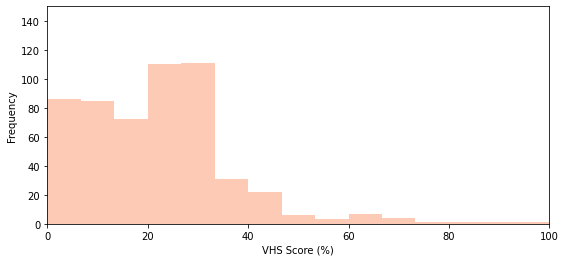

In [282]:
plt.figure(figsize=(9,4))
plt.hist(df['vhs_score'], color=get_arr_colors(5)[0],bins=15)
plt.ylim(0,150)
plt.xlim(0, 100)
plt.xlabel('VHS Score (%)')
plt.ylabel('Frequency')
plt.savefig('figures/fig_2_a.eps')
plt.show()
plt.close()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<Figure size 432x288 with 0 Axes>

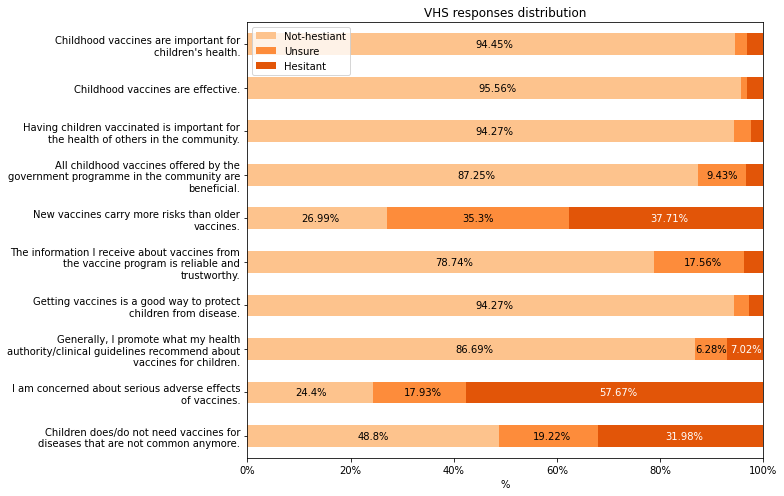

In [406]:
## VHS Distributions
plt.figure()
colors = get_arr_colors(3, 'Oranges',lower=0.3, upper=0.7)
dark = [colors[2]]
barh_df = (df[vhs_total].apply(pd.value_counts).sort_index(ascending=True).apply(lambda x: round(x/len(df)*100, 2))).transpose().iloc[::-1]
ax = barh_df.plot(kind='barh', stacked=True, figsize=(11,7), color=colors)
for p in ax.patches:
    if p.get_width()>5:
        cur_text_color = 'black'
        if all(p.get_facecolor() == dark[0]):
            cur_text_color = 'white'
        ax.annotate(str(round(p.get_width(), 2)) + '%', (p.get_x() + p.get_width()/2 -3, p.get_y()+0.18 ), color=cur_text_color)
ax.set_yticklabels(['\n'.join(textwrap.wrap(x, 45)) for x in barh_df.transpose().columns])
ax.xaxis.set_major_formatter(mtick.PercentFormatter())
ax.set_xlim(0,100)
ax.set_title('VHS responses distribution')
ax.legend(labels=["Not-hestiant","Unsure", "Hesitant"])
ax.set_xlabel('%')
plt.tight_layout()
plt.savefig('figures/fig_1.eps')

In [300]:
import pingouin as pg

pg.cronbach_alpha(data=df[vhs_total])

(0.6596390914686724, array([0.615, 0.701]))

C:\tools\Anaconda3\lib\site-packages\outdated\utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.3, the latest is 0.5.5.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


## Useful to vaccinate against

In [ ]:
df[useful_to_vaccinate_against].apply(pd.value_counts).sort_index()

In [364]:
df[useful_to_vaccinate_against[0]].value_counts().index

Index(['strongly agree', 'somewhat agree', 'somewhat disagree',
       'strongly disagree'],
      dtype='object')

In [399]:
df[useful_to_vaccinate_against] = df[useful_to_vaccinate_against].applymap(lambda x: x.capitalize())

In [401]:
for col in useful_to_vaccinate_against:
    df[col] = pd.Categorical(df[col], ['Strongly disagree', 'Somewhat disagree','Somewhat agree', 'Strongly agree'])

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<Figure size 432x288 with 0 Axes>

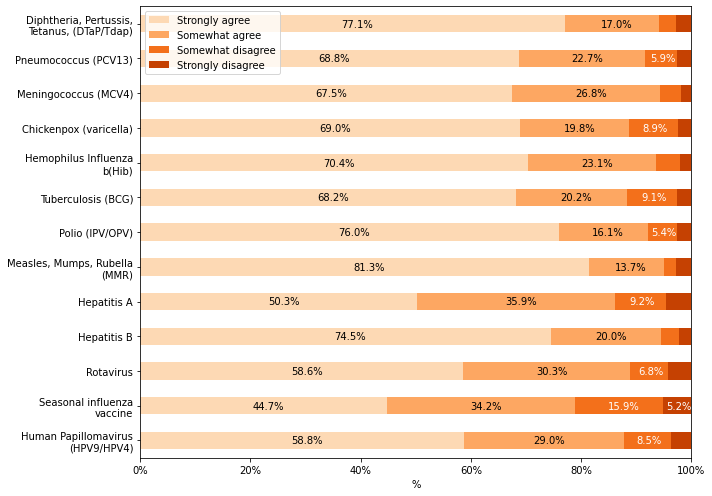

In [405]:
## Very useful to vaccinate against the following Distributions
## "To what extent do you AGREE that it is very useful to vaccinate children against the following?"
plt.figure()
colors = get_arr_colors(4, 'Oranges',lower=0.2, upper=0.8)
dark = [colors[2], colors[3]]
barh_df = (df[useful_to_vaccinate_against].apply(pd.value_counts).sort_index(ascending=False).apply(lambda x: round(x/len(df)*100, 2))).transpose().iloc[::-1]
ax = barh_df.plot(kind='barh', stacked=True, figsize=(10,7), color=colors)
for p in ax.patches:
    if p.get_width()>5:
        cur_text_color = 'black'
        if all(p.get_facecolor() == dark[0]) or all(p.get_facecolor() == dark[1]) :
            cur_text_color = 'white'
        ax.annotate(str(round(p.get_width(), 1)) + '%', (p.get_x() + p.get_width()/2 -2, p.get_y()+0.16 ), color=cur_text_color)
ax.set_yticklabels(['\n'.join(textwrap.wrap(x, 25)) for x in barh_df.transpose().columns])
ax.xaxis.set_major_formatter(mtick.PercentFormatter())
ax.set_xlim(0,100)
ax.set_xlabel('%')
plt.tight_layout()
plt.savefig('figures/fig_2.eps')

In [359]:

cur_df = df[useful_to_vaccinate_against].apply(pd.value_counts)
for col in cur_df:
    cur_sum = cur_df[col].sum()
    cur_df['%'] = cur_df[col].apply(lambda x: round(x*100/cur_sum, 2))
    cur_df[col] = cur_df.apply(lambda x: '{}% (n={}/{})'.format(x['%'], int(x[col]), int(df[col].notna().sum())), axis=1)
    cur_df = cur_df.drop('%', axis=1)
cur_df = cur_df.transpose()
# cur_df.columns = ['Not hesitant', 'Unsure', 'Hesitant']
display(cur_df)
print(cur_df.to_csv())

,somewhat agree,somewhat disagree,strongly agree,strongly disagree
"Diphtheria, Pertussis, Tetanus, (DTaP/Tdap)",17.01% (n=92/541),3.14% (n=17/541),77.08% (n=417/541),2.77% (n=15/541)
Pneumococcus (PCV13),22.74% (n=123/541),5.91% (n=32/541),68.76% (n=372/541),2.59% (n=14/541)
Meningococcus (MCV4),26.8% (n=145/541),3.88% (n=21/541),67.47% (n=365/541),1.85% (n=10/541)
Chickenpox (varicella),19.78% (n=107/541),8.87% (n=48/541),68.95% (n=373/541),2.4% (n=13/541)
Hemophilus Influenza b(Hib),23.11% (n=125/541),4.44% (n=24/541),70.43% (n=381/541),2.03% (n=11/541)
Tuberculosis (BCG),20.15% (n=109/541),9.06% (n=49/541),68.21% (n=369/541),2.59% (n=14/541)
Polio (IPV/OPV),16.08% (n=87/541),5.36% (n=29/541),75.97% (n=411/541),2.59% (n=14/541)
"Measles, Mumps, Rubella (MMR)",13.68% (n=74/541),2.22% (n=12/541),81.33% (n=440/541),2.77% (n=15/541)
Hepatitis A,35.86% (n=194/541),9.24% (n=50/541),50.28% (n=272/541),4.62% (n=25/541)
Hepatitis B,19.96% (n=108/541),3.33% (n=18/541),74.49% (n=403/541),2.22% (n=12/541)


,somewhat agree,somewhat disagree,strongly agree,strongly disagree
"Diphtheria, Pertussis, Tetanus, (DTaP/Tdap)",17.01% (n=92/541),3.14% (n=17/541),77.08% (n=417/541),2.77% (n=15/541)
Pneumococcus (PCV13),22.74% (n=123/541),5.91% (n=32/541),68.76% (n=372/541),2.59% (n=14/541)
Meningococcus (MCV4),26.8% (n=145/541),3.88% (n=21/541),67.47% (n=365/541),1.85% (n=10/541)
Chickenpox (varicella),19.78% (n=107/541),8.87% (n=48/541),68.95% (n=373/541),2.4% (n=13/541)
Hemophilus Influenza b(Hib),23.11% (n=125/541),4.44% (n=24/541),70.43% (n=381/541),2.03% (n=11/541)
Tuberculosis (BCG),20.15% (n=109/541),9.06% (n=49/541),68.21% (n=369/541),2.59% (n=14/541)
Polio (IPV/OPV),16.08% (n=87/541),5.36% (n=29/541),75.97% (n=411/541),2.59% (n=14/541)
"Measles, Mumps, Rubella (MMR)",13.68% (n=74/541),2.22% (n=12/541),81.33% (n=440/541),2.77% (n=15/541)
Hepatitis A,35.86% (n=194/541),9.24% (n=50/541),50.28% (n=272/541),4.62% (n=25/541)
Hepatitis B,19.96% (n=108/541),3.33% (n=18/541),74.49% (n=403/541),2.22%

## Bivariate Testing

### General functions needed for bivariate and multivariate analysis

In [336]:
mv_df = df[['Sex', 'Occupation', 'Health Authority',
       'Workplace', 'Total Years of Practice',
       'Number of patients seen in a week',
       'Have you received the COVID-19 vaccine?',
       'Have you received the influenza vaccine last year?',
        'What is your main source of information about vaccines recommendation and their safety? - Social media',
        'How many patients in your practice had a vaccine preventable disease (OTHER THAN COVID-19) in the last year?',
'vhs_hesitancy']]
mv_df.dropna(inplace=True)

<ipython-input-336-33866ab1321f>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mv_df.dropna(inplace=True)


In [337]:
#Cleaning and combining
mv_df['Have you received the COVID-19 vaccine?'].replace({'no':'no/ yes, 1 dose/2 doses',
        'yes, 1 dose/2 doses':'no/ yes, 1 dose/2 doses'}, inplace=True)

<ipython-input-337-a5c1aa41e68f>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mv_df['Have you received the COVID-19 vaccine?'].replace({'no':'no/ yes, 1 dose/2 doses',


In [338]:
for col in mv_df.columns:
    show_full_value_counts(mv_df, col)

,"Sex, % (total=541)"
female,59.52% (n=322/541)
male,40.48% (n=219/541)


Missing cases= 0.0% (n=0/541)


,"Occupation, % (total=541)"
dentist,9.98% (n=54/541)
nurse,6.65% (n=36/541)
other hcp,2.77% (n=15/541)
pharmacist,10.72% (n=58/541)
physician,69.87% (n=378/541)


Missing cases= 0.0% (n=0/541)


,"Health Authority, % (total=541)"
dha,31.98% (n=173/541)
doh/haad/seha,23.66% (n=128/541)
ehs,44.36% (n=240/541)


Missing cases= 0.0% (n=0/541)


,"Workplace, % (total=541)"
government hospital,61.74% (n=334/541)
other,4.99% (n=27/541)
primary healthcare,9.8% (n=53/541)
private clinic/hospital,23.48% (n=127/541)


Missing cases= 0.0% (n=0/541)


,"Total Years of Practice, % (total=541)"
entry level,46.03% (n=249/541)
mid level,26.8% (n=145/541)
senior level,27.17% (n=147/541)


Missing cases= 0.0% (n=0/541)


,"Number of patients seen in a week, % (total=541)"
1 to 19,27.54% (n=149/541)
20 to 49,39.56% (n=214/541)
50 and above,32.9% (n=178/541)


Missing cases= 0.0% (n=0/541)


,"Have you received the COVID-19 vaccine?, % (total=541)"
"no/ yes, 1 dose/2 doses",37.34% (n=202/541)
"yes, 3 doses",37.71% (n=204/541)
"yes, 4 doses or more",24.95% (n=135/541)


Missing cases= 0.0% (n=0/541)


,"Have you received the influenza vaccine last year?, % (total=541)"
no,52.13% (n=282/541)
yes,47.87% (n=259/541)


Missing cases= 0.0% (n=0/541)


,"What is your main source of information about vaccines recommendation and their safety? - Social media, % (total=541)"
False,88.17% (n=477/541)
True,11.83% (n=64/541)


Missing cases= 0.0% (n=0/541)


,"How many patients in your practice had a vaccine preventable disease (OTHER THAN COVID-19) in the last year?, % (total=541)"
few cases,40.11% (n=217/541)
hundreds of cases and more,14.79% (n=80/541)
none,17.56% (n=95/541)
tens of cases,27.54% (n=149/541)


Missing cases= 0.0% (n=0/541)


,"vhs_hesitancy, % (total=541)"
False,95.56% (n=517/541)
True,4.44% (n=24/541)


Missing cases= 0.0% (n=0/541)


In [339]:
mv_df.columns = ['sex', 'occupation', 'authority',
       'workplace', 'yearsOfPractice', 'numPatientsSeen', 'receivedCovidVaccine', 'receivedCovidInfluenzaVaccine', 
       'knowledgeSourceSocialMedia', 'numPatients', 'hesitancy']

In [340]:
#Defining the demogrpahic variables to be used
categorical_demogs = ['sex',  'occupation', 'authority',
       'workplace', 'yearsOfPractice', 'numPatientsSeen', 'receivedCovidVaccine', 'receivedCovidInfluenzaVaccine', 
       'knowledgeSourceSocialMedia', 'numPatients']

continuous_demogs = []

In [341]:
for col in categorical_demogs:
    print(mv_df[col].value_counts().index)

Index(['female', 'male'], dtype='object')
Index(['physician', 'pharmacist', 'dentist', 'nurse', 'other hcp'], dtype='object')
Index(['ehs', 'dha', 'doh/haad/seha'], dtype='object')
Index(['government hospital', 'private clinic/hospital', 'primary healthcare',
       'other'],
      dtype='object')
Index(['entry level', 'senior level', 'mid level'], dtype='object')
Index(['20 to 49', '50 and above', '1 to 19'], dtype='object')
Index(['yes, 3 doses', 'no/ yes, 1 dose/2 doses', 'yes, 4 doses or more'], dtype='object')
Index(['no', 'yes'], dtype='object')
Index([False, True], dtype='bool')
Index(['few cases', 'tens of cases', 'none', 'hundreds of cases and more'], dtype='object')


In [350]:
predictors = [*categorical_demogs, *continuous_demogs]

predictors_base_group =['male',
              'physician',
               'ehs',
              'primary healthcare',
               'entry level',
               '1 to 19',
              'no/ yes, 1 dose/2 doses',
                        'no',
               False,
               'none',
               False]

base_group_dict = dict(zip(predictors, predictors_base_group))
base_cols_to_drop = ['{}_{}'.format(x, y) for (x,y) in zip(predictors, predictors_base_group)]


In [343]:
base_cols_to_drop

['sex_male',
 'occupation_physician',
 'authority_ehs',
 'workplace_primary healthcare',
 'yearsOfPractice_entry level',
 'numPatientsSeen_1 to 19',
 'receivedCovidVaccine_no/ yes, 1 dose/2 doses',
 'receivedCovidInfluenzaVaccine_no',
 'knowledgeSourceSocialMedia_False',
 'numPatients_none']

#Checking for Normality of the continuous variables to determine
#whether parametric or non-parametric techniques will be used.
#P-values < 0.05 indicate that the variable is non-normal
for col in continuous_demogs:
    print(stats.shapiro(df[col]))

In [351]:
#This assumes that there is a row called 'P-value' like that
def highlight_rows(row):
    value = row.loc['P-value']

    if (value!='-') and ((value=='<0.0005') or (float(value) <0.05 )):
        color = '#BAFFC9' # Green
    else:
        color = '#FFFFFF' # White
    return ['background-color: {}'.format(color) for r in row]

def boldify(row):
    value = row.loc['P-value']
    if (value!='-') and ((value=='<0.0005') or (float(value) <0.05 )):
        bold = 'bold' # Bold
    else:
        bold = '' # No Bold
    return ['font-weight: {}'.format(bold) for r in row]

# df is the dataframe for which the analysis will be performed
# factor is the independent feature according to which the type of bivariate test will be performed. Assumed to be categorical
# target is the name of feature that is the outcome of interest being studied.
# 
def perform_bivariate_test_cont(df, factor, target):
    val_counts = df[factor].value_counts()
    num_levels = len(val_counts.index)
    
#     2 --> Perform Mann-Whitney U Test
    if(num_levels==2):
        poss_vals = list(val_counts.index)
        res = stats.mannwhitneyu(df[df[factor]==poss_vals[0]][target],df[df[factor]==poss_vals[1]][target], alternative='two-sided' )
        return res.pvalue
    
#     More than 2 --> Perform Kruskall-Walis Test
    else:
        res =  stats.kruskal(*[df[df[factor]==val][target] for val in list(df[factor].value_counts().index)])
        return res.pvalue
    
def perform_chi_square(df, factor, target):
    cur_res = stats.chi2_contingency(pd.crosstab( df[factor], df[target]))
    return cur_res[1]

# A function that performs all the bivariate analysis and returns a bivariate df 
# containing all the p-values sorted from sig to non-sig
def perform_overall_bivariate(df, predictors, target):
    bivariate_df = pd.DataFrame([], columns=['Variable', 'P-value'])
    for col in predictors:
        if col in categorical_demogs:
            cur_p_value = perform_chi_square(df, col, target)
            cur_series = pd.DataFrame([[col, cur_p_value]], columns=['Variable', 'P-value'])
            bivariate_df = pd.concat([bivariate_df, cur_series], ignore_index=True)
        elif col in continuous_demogs:
            cur_p_value = perform_bivariate_test_cont(df, col, target)
            cur_series = pd.DataFrame([[col, cur_p_value]], columns=['Variable', 'P-value'])
            bivariate_df = pd.concat([bivariate_df, cur_series])
    return bivariate_df.sort_values(by='P-value').reset_index(drop=True)

#A helper function to round the p-values
def round_p_value(val):
    if (float(val)>=0.001):
        return str(val)
    else:
        return '<0.0005'

def add_blank_rows(table):
    table['main'] = pd.Series(['-']*(len(table)+1))
    last_row_main = ' '
    for i, row in table.iterrows():
        poss_main = [x for x in categorical_demogs if x in str(row['Variable'])]
        print(poss_main)
        if(len(poss_main)>0):
            if(poss_main[0]!=last_row_main):
                last_row_main=poss_main[0]
                table.loc[i-0.5] = pd.Series(['-']*len(table.columns), index=table.columns)
                table.loc[i-0.5, 'main'] = ' '.join(poss_main[0].split('_'))
                table.loc[i-0.5, 'Variable'] = base_group_dict[poss_main[0]]
            table.loc[i, 'main'] = ' '.join(poss_main[0].split('_'))
            table.loc[i, 'Variable'] = ' '.join(table.loc[i, 'Variable'].data.split(poss_main[0]+'_'))
#     table = table[['main', 'Variable', 'Co-ef', 'Std Error', 'z', 'P-value', 'Lower', 'Higher']]
    return table.sort_index().reset_index(drop=True)
    
    
#A function that performs the multivariate and returns the logit model
#to be used for analysis
#Please note that the predictors, categorical and continuous variables
#need to be defined before running it
def perform_multivariate_logit(df, predictors, target):
    
    #Overall bivariate analysis
    cur_bivariate = perform_overall_bivariate(df, predictors, target)
    display(cur_bivariate)
    
    
    #Getting the significant values
    sig_bivariate = cur_bivariate[cur_bivariate['P-value']<0.05]
    print('\n\n------- SIGNIFICANT VARIABLES ------\n')
    display(sig_bivariate)
    
    #Defining the multivar data to be able to use it in the modeling
    multivar_data = pd.get_dummies(df[sig_bivariate['Variable']])
    multivar_data = multivar_data.replace({True:1, False:0})
    multivar_cols_base = [x for x in base_cols_to_drop if x in multivar_data.columns]
    print(multivar_cols_base)
    print(multivar_data.columns)
    multivar_data = multivar_data.drop(multivar_cols_base, axis=1)
    
    #Displaying the multivar data
    display(multivar_data)
    
    #Building a logistic regression model
    mod = sm.Logit(df[target], sm.add_constant(multivar_data)).fit()
    display(mod.summary())
    
    #Exponentiating the co-efficients
    model_sum_table =  pd.DataFrame(mod.summary().tables[1], columns=['Variable', 'Co-ef', 'Std Error', 'z', 'P-value', 'Lower', 'Higher']).drop([0])
    model_sum_table['exp(co-ef)'] = model_sum_table['Co-ef'].apply(lambda x: '{0:.3f}'.format(np.exp(float(x.data))))
    model_sum_table['interval'] = model_sum_table.apply(lambda x: '{0:.3f}'.format(np.exp(float(x['Lower'].data))) + ' - ' + '{0:.3f}'.format(np.exp(float(x['Higher'].data))), axis=1)
    model_sum_table['P-value'] = model_sum_table['P-value'].apply(lambda x: round_p_value(x.data))
    model_sum_table = add_blank_rows(model_sum_table)
    model_sum_table = model_sum_table[['main', 'Variable', 'exp(co-ef)','interval', 'Std Error', 'z', 'P-value']]
    display(model_sum_table.style.apply(highlight_rows, axis=1).apply(boldify, axis=1))
    
    return mod

### Bivariate - Internet Freq Use

In [352]:
perform_multivariate_logit(mv_df, predictors, 'hesitancy')

,Variable,P-value
0,occupation,0.001968
1,yearsOfPractice,0.008282
2,receivedCovidVaccine,0.214182
3,numPatientsSeen,0.227871
4,receivedCovidInfluenzaVaccine,0.405556
5,sex,0.447739
6,workplace,0.494541
7,authority,0.739743
8,numPatients,0.750788
9,knowledgeSourceSocialMedia,0.826418




------- SIGNIFICANT VARIABLES ------



,Variable,P-value
0,occupation,0.001968
1,yearsOfPractice,0.008282


['occupation_physician', 'yearsOfPractice_entry level']
Index(['occupation_dentist', 'occupation_nurse', 'occupation_other hcp',
       'occupation_pharmacist', 'occupation_physician',
       'yearsOfPractice_entry level', 'yearsOfPractice_mid level',
       'yearsOfPractice_senior level'],
      dtype='object')


,occupation_dentist,occupation_nurse,occupation_other hcp,occupation_pharmacist,yearsOfPractice_mid level,yearsOfPractice_senior level
0,0,1,0,0,0,1
1,0,1,0,0,0,1
2,0,1,0,0,0,1
3,0,0,0,0,0,1
4,0,0,0,0,1,0
...,...,...,...,...,...,...
536,0,0,0,0,1,0
537,0,0,0,1,0,1
538,0,0,0,1,0,1
539,0,0,0,1,0,1


Optimization terminated successfully.
         Current function value: 0.161336
         Iterations 8


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              hesitancy   No. Observations:                  541
Model:                          Logit   Df Residuals:                      534
Method:                           MLE   Df Model:                            6
Date:                Tue, 15 Oct 2024   Pseudo R-squ.:                  0.1114
Time:                        03:27:57   Log-Likelihood:                -87.283
converged:                       True   LL-Null:                       -98.228
Covariance Type:            nonrobust   LLR p-value:                  0.001267
================================================================================================
                                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const                           -4.2534      0.486     -8.753      0.000      -5.206      -3.301
occupation_dentist               1.7430      0.577      3.022      0.003       0.613       2.873
occupation_nurse                 1.5197      0.738      2.058      0.040       0.073       2.967
occupation_other hcp             1.5124      0.861      1.758      0.079      -0.174       3.199
occupation_pharmacist            1.4419      0.596      2.420      0.016       0.274       2.610
yearsOfPractice_mid level        1.1579      0.503      2.302      0.021       0.172       2.144
yearsOfPractice_senior level    -0.0593      0.690     -0.086      0.932      -1.412       1.294
================================================================================================
"""

[]
['occupation']
['occupation']
['occupation']
['occupation']
['yearsOfPractice']
['yearsOfPractice']


,main,Variable,exp(co-ef),interval,Std Error,z,P-value
0,-,const,0.014,0.005 - 0.037,0.486,-8.753,<0.0005
1,occupation,physician,-,-,-,-,-
2,occupation,dentist,5.714,1.846 - 17.690,0.577,3.022,0.003
3,occupation,nurse,4.571,1.076 - 19.434,0.738,2.058,0.040
4,occupation,other hcp,4.538,0.840 - 24.508,0.861,1.758,0.079
5,occupation,pharmacist,4.229,1.315 - 13.599,0.596,2.420,0.016
6,yearsOfPractice,entry level,-,-,-,-,-
7,yearsOfPractice,mid level,3.183,1.188 - 8.534,0.503,2.302,0.021
8,yearsOfPractice,senior level,0.942,0.244 - 3.647,0.690,-0.086,0.932


In [355]:
df[df.vhs_hesitancy]

,Sex,Age,Citizenship,Occupation,Health Authority,Workplace,Total Years of Practice,Number of patients seen in a week,Have you received the COVID-19 vaccine?,Have you received the influenza vaccine last year?,...,What are the 5 most important factors to you personally when it comes to recommending a pediatric vaccine? - Individual health-risk profile of the child,What are the 5 most important factors to you personally when it comes to recommending a pediatric vaccine? - Other,What are the 5 most important factors to you personally when it comes to recommending a pediatric vaccine? - Personal experience with the disease,What are the 5 most important factors to you personally when it comes to recommending a pediatric vaccine? - Possibility to eradicate disease with vaccination,What are the 5 most important factors to you personally when it comes to recommending a pediatric vaccine? - Severity/lethality of the prevented disease,What are the 5 most important factors to you personally when it comes to recommending a pediatric vaccine? - Vaccine cost,What are the 5 most important factors to you personally when it comes to recommending a pediatric vaccine? - Vaccine effectiveness,What are the 5 most important factors to you personally when it comes to recommending a pediatric vaccine? - Vaccine safety,vhs_score,vhs_hesitancy
3,female,middle-aged/ old-aged adult,other arab,physician,dha,private clinic/hospital,senior level,50 and above,no,no,...,False,False,False,False,False,False,False,False,100,True
42,male,young adult,other arab,physician,ehs,government hospital,mid level,20 to 49,"yes, 1 dose/2 doses",no,...,False,False,False,True,False,True,False,True,60,True
60,female,young adult,other arab,physician,dha,government hospital,entry level,20 to 49,"yes, 1 dose/2 doses",no,...,False,False,False,False,False,False,False,False,70,True
64,female,young adult,other arab,physician,doh/haad/seha,government hospital,entry level,20 to 49,"yes, 1 dose/2 doses",yes,...,False,False,False,False,False,False,False,False,55,True
69,male,young adult,other arab,physician,doh/haad/seha,government hospital,entry level,20 to 49,"yes, 4 doses or more",yes,...,False,False,True,False,False,False,False,False,50,True
96,male,young adult,other arab,pharmacist,dha,private clinic/hospital,mid level,50 and above,"yes, 1 dose/2 doses",no,...,False,False,False,True,False,False,False,True,50,True
97,male,young adult,other arab,nurse,ehs,government hospital,senior level,20 to 49,"yes, 1 dose/2 doses",no,...,True,False,False,True,True,True,False,False,60,True
104,male,young adult,other arab,dentist,doh/haad/seha,private clinic/hospital,entry level,1 to 19,"yes, 3 doses",no,...,True,False,False,False,False,False,True,True,60,True
127,male,young adult,other arab,physician,dha,government hospital,mid level,50 and above,"yes, 4 doses or more",no,...,False,False,True,False,False,True,True,True,60,True
205,male,young adult,other arab,dentist,ehs,government hospital,entry level,1 to 19,"yes, 3 doses",no,...,True,False,False,False,False,False,True,True,50,True
